In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4329.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4223.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4253.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4190.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4354.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4136.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4226.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4214.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4888.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4170.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4323.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4262.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4788.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4657.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4387.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4255.jpg
/kaggle/

In [15]:
import os


!ls /kaggle/input/cat-and-dog


test_set  training_set


## Ortam ve Kütüphane Ayarları
Bu bölümde proje için gerekli kütüphaneler (TensorFlow, Keras, NumPy, Matplotlib vb.) içe aktarılmıştır.  
- TensorFlow uyarılarının azaltılması için log seviyeleri düşürülmüştür.  
- GPU kullanımı ayarlanmış ve bellek kullanımının kontrollü artması sağlanmıştır.  
- Deneylerin tekrarlanabilir olması için `SEED` değeri 42 olarak belirlenmiş, NumPy, TensorFlow ve Python’un random modülü için rastgelelik sabitlenmiştir.


In [16]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"  
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true" 

from absl import logging
logging.set_verbosity(logging.ERROR)

import os, random
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED); random.seed(SEED)


TensorFlow: 2.18.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Veri Seti Yolları ve Parametreler
Bu bölümde Kaggle üzerinde kullanılan **Cats vs Dogs** veri setinin dizinleri tanımlanmıştır:  
- `train_root` → eğitim verilerinin bulunduğu klasör  
- `test_root` → test verilerinin bulunduğu klasör  

Ayrıca modelde kullanılacak temel parametreler belirlenmiştir:  
- **IMG_SIZE = 224** → Görseller bu boyuta yeniden ölçeklendirilecektir.  
- **BATCH_SIZE = 32** → Eğitim sırasında aynı anda işlenecek örnek sayısı.  
- **AUTOTUNE** → TensorFlow’un veri yükleme performansını otomatik optimize etmesi için.  


In [17]:

base_dir = Path("/kaggle/input/cat-and-dog")

train_root = base_dir / "training_set" / "training_set"
test_root  = base_dir / "test_set" / "test_set"

print("Train root:", train_root)
print("Test  root:", test_root)
print("Train exists:", train_root.exists(), "| Test exists:", test_root.exists())


IMG_SIZE   = 224
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE


Train root: /kaggle/input/cat-and-dog/training_set/training_set
Test  root: /kaggle/input/cat-and-dog/test_set/test_set
Train exists: True | Test exists: True


## Veri Yükleme ve Ön İşleme
Bu bölümde eğitim, doğrulama ve test verileri TensorFlow’un `image_dataset_from_directory` fonksiyonu ile yüklenmiştir.  

- **Data Augmentation:**  
  - `RandomFlip("horizontal")`: Görüntüleri yatay olarak çevirir.  
  - `RandomRotation(0.05)`: Küçük açılarla döndürme uygular.  
  - `RandomZoom(0.1)`: Hafif yakınlaştırma/uzaklaştırma uygular.  
  Bu işlemler modelin çeşitlilik görmesini sağlar ve aşırı öğrenmeyi (overfitting) azaltır.  

- **Normalizasyon:**  
  `Rescaling(1./255)` ile pikseller 0–255 aralığından 0–1 aralığına dönüştürülür.  

- **Veri Seti Bölünmesi:**  
  - `train_ds`: %90 eğitim verisi  
  - `val_ds`: %10 doğrulama verisi  
  - `test_ds`: Kaggle veri setindeki test klasörü  

- **Sınıflar:** `class_names` ile `['cats', 'dogs']` etiketleri elde edilmiştir.  

- **Prefetch:** TensorFlow veri pipeline’ının GPU/CPU kullanımını optimize etmesi için eklenmiştir.


In [18]:

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augmentation")

normalization = layers.Rescaling(1./255)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_root,
    labels="inferred",
    label_mode="int",
    validation_split=0.10,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_root,
    labels="inferred",
    label_mode="int",
    validation_split=0.10,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_root,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
print("Classes:", class_names)


train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 8005 files belonging to 2 classes.
Using 7205 files for training.
Found 8005 files belonging to 2 classes.
Using 800 files for validation.
Found 2023 files belonging to 2 classes.
Classes: ['cats', 'dogs']


## Baseline CNN: Mimari, Eğitim ve Öğrenme Eğrileri
Bu bölümde sıfırdan küçük bir **CNN tabanlı model** kurulmuş, eğitilmiş ve sonuçları görselleştirilmiştir.

**Mimari:**
- Giriş: `IMG_SIZE×IMG_SIZE×3`
- **Veri artırma** (`data_augmentation`) ve **normalizasyon** (`Rescaling`)
- Konvolüsyon blokları:  
  - `Conv2D(32, 3)` → `MaxPooling2D()`  
  - `Conv2D(64, 3)` → `MaxPooling2D()`  
  - `Conv2D(128, 3)`  
- **GlobalAveragePooling2D**: Özellik haritalarını sıkıştırır.
- **Dropout (0.3)**: Aşırı öğrenmeyi azaltmak için.
- Tam bağlantılı katman: `Dense(128, relu)`
- Çıkış: `Dense(1, sigmoid)` → **ikili sınıflandırma** (kedi/köpek)

**Eğitim Ayarları:**
- Kayıp: `binary_crossentropy`
- Optimizasyon: `Adam(lr=1e-3)`
- Metrik: `accuracy`
- Epoch: `EPOCHS_BASE = 5` (hızlı ilk deneme)

**Callback’ler:**
- `ModelCheckpoint`: En iyi **doğrulama doğruluğunu** veren ağırlıkları `/kaggle/working/cvd_baseline.keras` olarak kaydeder.
- `EarlyStopping (patience=3)`: Aşırı eğitimi önlemek için erken durdurma ve **en iyi ağırlıkları geri yükleme**.
- `ReduceLROnPlateau`: Doğrulama kaybı iyileşmediğinde öğrenme oranını yarıya indirir.

**Görselleştirme:**
- Eğitim/Doğrulama **Accuracy** ve **Loss** eğrileri çizdirilerek modelin öğrenme dinamikleri değerlendirilir.


Epoch 1/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5213 - loss: 0.6927
Epoch 1: val_accuracy improved from -inf to 0.57875, saving model to /kaggle/working/cvd_baseline.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.5213 - loss: 0.6927 - val_accuracy: 0.5788 - val_loss: 0.6719 - learning_rate: 0.0010
Epoch 2/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5409 - loss: 0.6863
Epoch 2: val_accuracy did not improve from 0.57875
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.5410 - loss: 0.6863 - val_accuracy: 0.5475 - val_loss: 0.6740 - learning_rate: 0.0010
Epoch 3/5
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5808 - loss: 0.6699
Epoch 3: val_accuracy improved from 0.57875 to 0.63250, saving model to /kaggle/working/cvd_baseline.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.5808 - loss: 0.6699 - val_accuracy: 0.6325 - val_loss: 0.6461 - learning_rate: 0.0010
Epoch 4/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

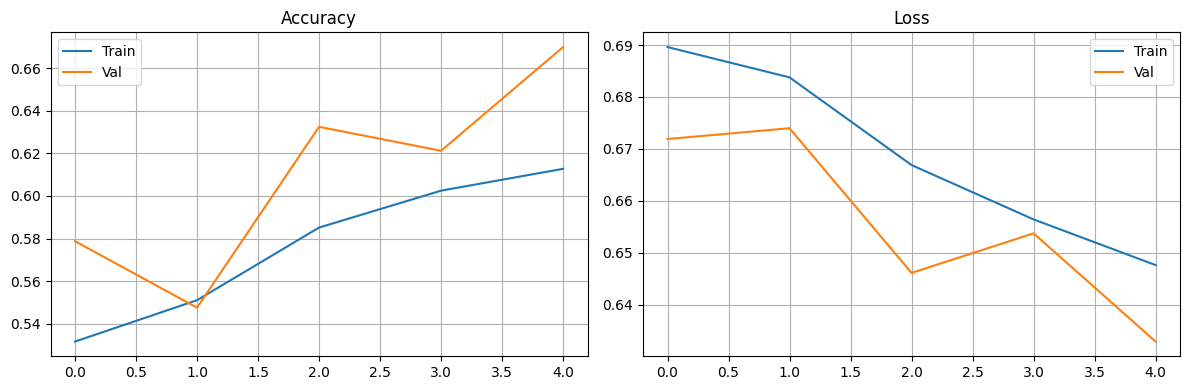

In [19]:
def build_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), dropout=0.3):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = normalization(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # binary
    return keras.Model(inputs, outputs, name="baseline_cnn")

baseline = build_baseline_cnn()
baseline.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_BASE = 5  
ckpt_base = "/kaggle/working/cvd_baseline.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_base, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]

hist_base = baseline.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_BASE,
    callbacks=callbacks,
    verbose=1
)


plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(hist_base.history["accuracy"], label="Train"); plt.plot(hist_base.history["val_accuracy"], label="Val"); plt.title("Accuracy"); plt.legend(); plt.grid(True)
plt.subplot(1,2,2); plt.plot(hist_base.history["loss"], label="Train"); plt.plot(hist_base.history["val_loss"], label="Val"); plt.title("Loss"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()






## Baseline Model Değerlendirme (Test Seti)
Bu bölümde **baseline CNN** modelinin test performansı ölçülmüş ve farklı metriklerle görselleştirilmiştir.

- **Değerlendirme:** `baseline.evaluate(test_ds)` ile **Test Accuracy** ve **Test Loss** hesaplanır.
- **Tahminler:** Modelin her batch için ürettiği olasılıklar (`y_prob`) toplanır, `0.5` eşik değeri ile sınıf tahminleri (`y_pred`) elde edilir.
- **Sınıflandırma Raporu:** `precision`, `recall`, `f1-score` ve **destek (support)** değerlerini sınıf bazında gösterir.
- **Confusion Matrix:** Doğru/yanlış sınıflandırmaları görselleştirerek **hangi sınıfta karışma** olduğunu ortaya koyar.
- **ROC Eğrisi & AUC:** Olasılık tabanlı ayrım gücünü gösterir; **AUC** değeri 1’e yaklaştıkça modelin ayırt ediciliği artar.
- **Precision–Recall Eğrisi & AP:** Özellikle dengesiz veri durumlarında faydalıdır; **AP** (average precision) yüksekse modelin pozitif sınıfı yakalama başarısı iyidir.
- **Macro F1:** Sınıflar arası ortalamayı alır; sınıf dengesizliğine daha duyarlı, **genel dengeyi** gösteren bir ölçüttür.

> Not: Eşik değeri (`0.5`) proje ihtiyacına göre ayarlanabilir. ROC/PR eğrilerinden yararlanarak farklı eşikler denenebilir.


[Baseline] Test Accuracy: 0.6550 | Test Loss: 0.6336

Classification report:
               precision    recall  f1-score   support

        cats     0.6646    0.6251    0.6442      1011
        dogs     0.6465    0.6848    0.6651      1012

    accuracy                         0.6550      2023
   macro avg     0.6555    0.6550    0.6547      2023
weighted avg     0.6555    0.6550    0.6547      2023

Confusion Matrix:
 [[632 379]
 [319 693]]


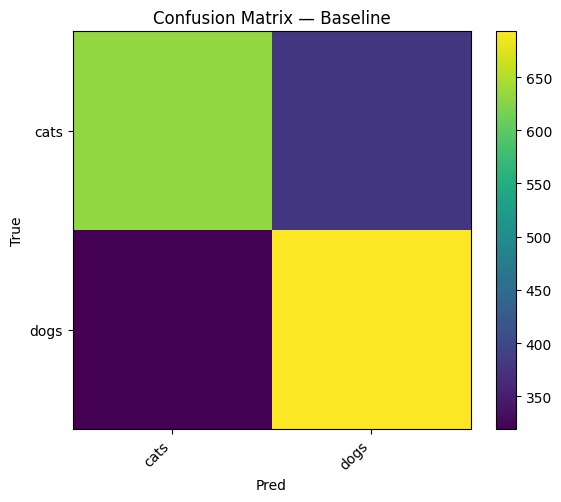

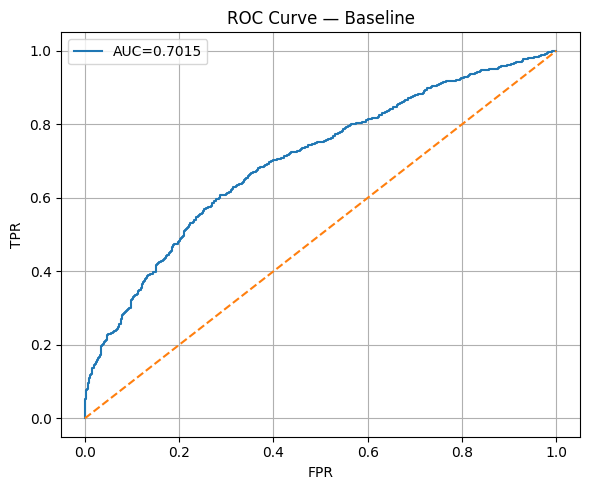

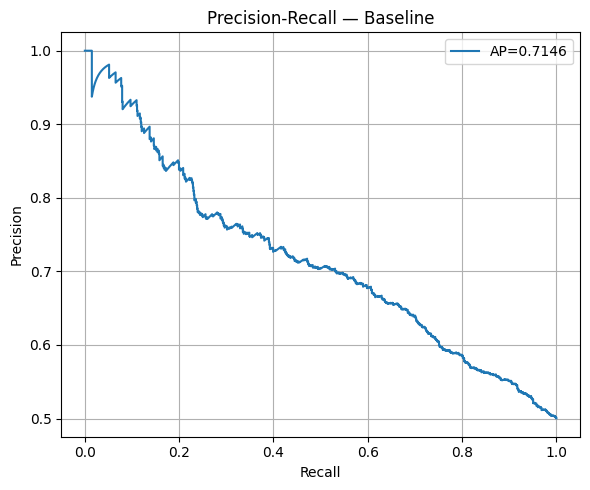

Macro F1: 0.6547


In [20]:

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

test_loss, test_acc = baseline.evaluate(test_ds, verbose=0)
print(f"[Baseline] Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

y_true, y_prob = [], []
for images, labels in test_ds:
    probs = baseline.predict(images, verbose=0).squeeze()
    y_prob.extend(probs.tolist())
    y_true.extend(labels.numpy().tolist())
y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)


print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix — Baseline")
plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45, ha='right')
plt.yticks(ticks, class_names)
plt.ylabel("True"); plt.xlabel("Pred")
plt.tight_layout(); plt.show()

auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve — Baseline"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

ap = average_precision_score(y_true, y_prob)
prec, rec, _ = precision_recall_curve(y_true, y_prob)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP={ap:.4f}")
plt.title("Precision-Recall — Baseline"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

print("Macro F1:", round(f1_score(y_true, y_pred, average="macro"), 4))


## Transfer Learning: MobileNetV2 Modeli
Bu bölümde **Transfer Learning** yaklaşımı kullanılarak **MobileNetV2** tabanlı bir model oluşturulmuştur.

- **MobileNetV2 Base Modeli:**
  - `keras.applications.MobileNetV2` ImageNet üzerinde önceden eğitilmiş ağırlıklarla yüklenmiştir.
  - `include_top=False` seçeneği ile sadece **özellik çıkarıcı** katmanlar alınmış, sınıflandırma katmanı çıkarılmıştır.
  - `base.trainable = False` → İlk aşamada taban katmanlar dondurulmuş, sadece yeni eklenen katmanlar eğitilecektir.

- **Eklenen Katmanlar:**
  - **Veri artırma (`data_augmentation`)** ve **ön işleme (`preprocess_input`)**
  - **Global Average Pooling:** Özellik haritalarını sıkıştırır.
  - **Dropout (0.2):** Aşırı öğrenmeyi engellemek için.
  - **Çıkış Katmanı:** `Dense(1, sigmoid)` → ikili sınıflandırma (kedi/köpek)

- **Eğitim Ayarları:**
  - Optimizasyon: `Adam(lr=1e-3)`
  - Kayıp: `binary_crossentropy`
  - Metrik: `accuracy`

- **Amaç:**  
  Önceden eğitilmiş ağın görsel özelliklerinden faydalanarak daha yüksek doğruluk elde etmek ve baseline CNN ile performans farkını görmek.


In [21]:
from tensorflow import keras
from tensorflow.keras import layers

def build_mobilenet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), dropout=0.2):
    base = keras.applications.MobileNetV2(
        input_shape=input_shape, include_top=False, weights="imagenet"
    )
    base.trainable = False  

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = keras.applications.mobilenet_v2.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # binary
    model = keras.Model(inputs, outputs, name="mobilenetv2_transfer")
    return model, base

transfer, base = build_mobilenet_model()
transfer.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
transfer.summary()


Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## MobileNetV2: Üst Katmanların Eğitimi
Bu aşamada MobileNetV2 tabanlı transfer learning modelinde yalnızca **üst katmanlar** eğitilmiştir.  
Taban (base) model katmanları dondurulduğu için yalnızca son eklenen sınıflandırma katmanları güncellenmiştir.

- **Eğitim Ayarları:**
  - Epoch sayısı: `EPOCHS_TOP = 3` (hızlı ilk deneme)
  - Callback’ler:
    - **ModelCheckpoint:** En iyi doğrulama doğruluğuna sahip ağırlıkları kaydeder.
    - **EarlyStopping:** Doğrulama doğruluğu iyileşmezse eğitimi erken sonlandırır ve en iyi ağırlıkları geri yükler.

- **Sonuçların Görselleştirilmesi:**
  - Eğitim ve doğrulama **doğruluk (accuracy)** grafiği
  - Eğitim ve doğrulama **kayıp (loss)** grafiği

> Bu aşama ile modelin önceden öğrenilmiş görsel özellikleri kullanılarak baseline CNN’e göre çok daha hızlı ve yüksek doğrulukta sonuç elde edilmesi beklenir.


Epoch 1/3
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9096 - loss: 0.2218
Epoch 1: val_accuracy improved from -inf to 0.98375, saving model to /kaggle/working/cvd_mobilenetv2_top.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.9100 - loss: 0.2209 - val_accuracy: 0.9837 - val_loss: 0.0413
Epoch 2/3
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9749 - loss: 0.0645
Epoch 2: val_accuracy improved from 0.98375 to 0.99125, saving model to /kaggle/working/cvd_mobilenetv2_top.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.9750 - loss: 0.0644 - val_accuracy: 0.9912 - val_loss: 0.0350
Epoch 3/3
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9794 - loss: 0.0547
Epoch 3: val_accuracy improved from 0.99125 to 0.99250, saving model to /kaggle/working/cvd_mobilenetv2_top.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.9794 - loss: 0.0546 - val_accuracy: 0.9925 - val_loss: 0.0264


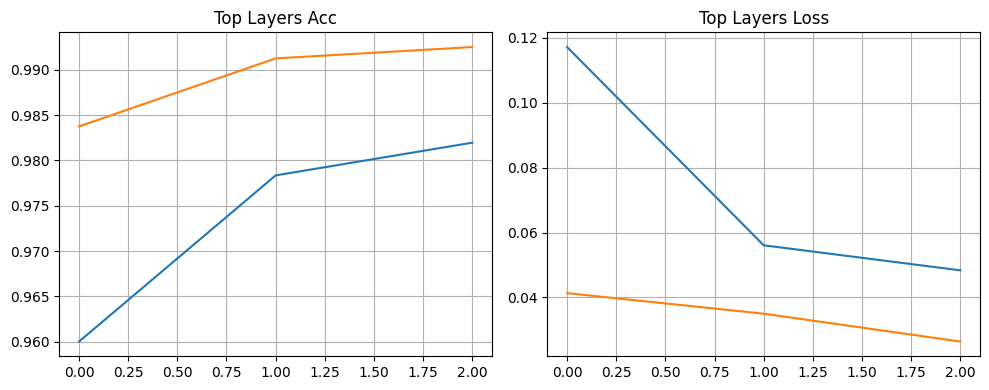

In [22]:
EPOCHS_TOP = 3
ckpt_top = "/kaggle/working/cvd_mobilenetv2_top.keras"

callbacks_top = [
    keras.callbacks.ModelCheckpoint(ckpt_top, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True),
]

hist_top = transfer.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_TOP, callbacks=callbacks_top, verbose=1
)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(hist_top.history["accuracy"]); plt.plot(hist_top.history["val_accuracy"]); plt.title("Top Layers Acc"); plt.grid(True)
plt.subplot(1,2,2); plt.plot(hist_top.history["loss"]); plt.plot(hist_top.history["val_loss"]); plt.title("Top Layers Loss"); plt.grid(True)
plt.tight_layout(); plt.show()


## MobileNetV2: Fine-Tuning (Son Katmanların Açılması)
Bu aşamada MobileNetV2’nin taban katmanlarının bir kısmı **eğitilebilir** hale getirilmiştir.  
Böylece model, sadece eklenen sınıflandırma katmanlarını değil, aynı zamanda **önceden öğrenilmiş özelliklerin son %30’unu** da güncelleyerek veri setine daha iyi uyum sağlayabilir.

- **Katmanların Eğitilebilirliği:**
  - `for i, layer in enumerate(base.layers): layer.trainable = (i >= len(base.layers) * 0.7)`  
  - Yani taban modelin ilk %70’i dondurulmuş, son %30’u açılmıştır.

- **Eğitim Ayarları:**
  - Öğrenme oranı: `1e-5` (çok düşük, çünkü fine-tuning aşamasında büyük adımlarla öğrenmek risklidir)
  - Epoch sayısı: `EPOCHS_FT = 5`
  - Callback’ler:
    - **ModelCheckpoint:** En iyi doğrulama doğruluğunu kaydeder.
    - **EarlyStopping:** İyileşme olmazsa eğitimi durdurur ve en iyi ağırlıkları geri yükler.
    - **ReduceLROnPlateau:** Doğrulama kaybı iyileşmediğinde öğrenme oranını daha da düşürür.

- **Sonuçların Görselleştirilmesi:**
  - Eğitim ve doğrulama **doğruluk (accuracy)** eğrileri
  - Eğitim ve doğrulama **kayıp (loss)** eğrileri

> Fine-tuning aşamasında modelin doğrulama doğruluğunun (val_accuracy) daha da artması, kaybın (val_loss) azalması ve modelin dataset’e daha iyi genelleme yapması beklenir.


Epoch 1/5
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8796 - loss: 0.3014
Epoch 1: val_accuracy improved from -inf to 0.98625, saving model to /kaggle/working/cvd_mobilenetv2_finetuned.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.8800 - loss: 0.3003 - val_accuracy: 0.9862 - val_loss: 0.0511 - learning_rate: 1.0000e-05
Epoch 2/5
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9605 - loss: 0.0993
Epoch 2: val_accuracy improved from 0.98625 to 0.98875, saving model to /kaggle/working/cvd_mobilenetv2_finetuned.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.9606 - loss: 0.0992 - val_accuracy: 0.9887 - val_loss: 0.0326 - learning_rate: 1.0000e-05
Epoch 3/5
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9699 - loss: 0.0745
Epoch 3: val_accuracy improved from 0.98875 to 0.99000, saving model to /kaggle/working/cvd_mobilenetv2_finetuned.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.9699 - loss: 0.0745 - val_accurac

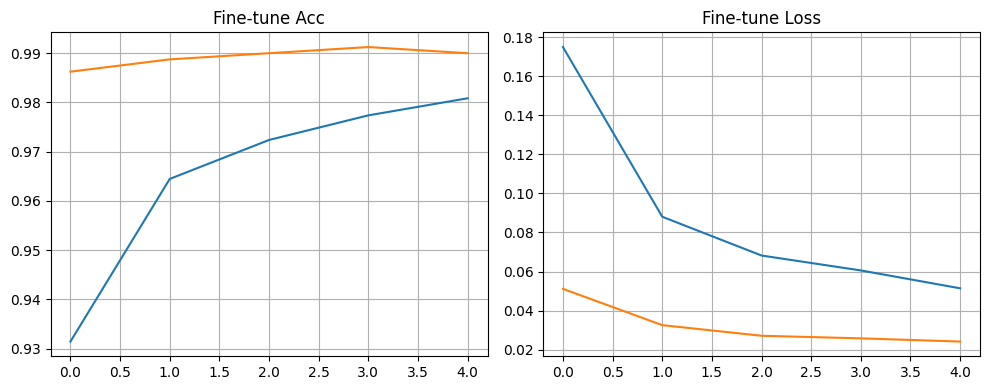

In [23]:

for i, layer in enumerate(base.layers):
    layer.trainable = (i >= int(len(base.layers) * 0.7))

transfer.compile(
    optimizer=keras.optimizers.Adam(1e-5), 
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_FT = 5
ckpt_ft = "/kaggle/working/cvd_mobilenetv2_finetuned.keras"
callbacks_ft = [
    keras.callbacks.ModelCheckpoint(ckpt_ft, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1),
]

hist_ft = transfer.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_FT, callbacks=callbacks_ft, verbose=1
)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(hist_ft.history["accuracy"]); plt.plot(hist_ft.history["val_accuracy"]); plt.title("Fine-tune Acc"); plt.grid(True)
plt.subplot(1,2,2); plt.plot(hist_ft.history["loss"]); plt.plot(hist_ft.history["val_loss"]); plt.title("Fine-tune Loss"); plt.grid(True)
plt.tight_layout(); plt.show()


## Transfer Modeli: Test Değerlendirme ve Modelin Kaydedilmesi
Bu bölümde **MobileNetV2 transfer learning** modelinin test performansı ölçülmüş, metrikler görselleştirilmiş ve son olarak model disk’e kaydedilmiştir.

- **Değerlendirme:**  
  `transfer.evaluate(test_ds)` ile **Test Accuracy** ve **Test Loss** hesaplanır.

- **Tahmin Akışı:**  
  Test kümesi üzerinde model olasılık çıktıları (`y_prob`) toplanır; `0.5` eşik değeri ile sınıf tahminleri (`y_pred`) oluşturulur.

- **Sınıflandırma Raporu:**  
  `classification_report` sınıf bazında **precision**, **recall**, **f1-score** ve **support** değerlerini verir.

- **Confusion Matrix:**  
  Doğru/yanlış sınıflandırmaları görselleştirerek hangi sınıfların karıştığını gösterir.

- **ROC Eğrisi & AUC:**  
  Olasılık tabanlı ayrım gücünü gösterir; **AUC** değeri 1’e yaklaştıkça modelin ayırt ediciliği artar.

- **Precision–Recall Eğrisi & AP:**  
  Özellikle dengesiz veri senaryolarında önemlidir; **AP (average precision)** yüksekse pozitif sınıfı iyi yakalıyorsunuz demektir.

- **Macro F1:**  
  Sınıflar arası ortalama F1; sınıf dengesizliğine daha duyarlı bir genel başarı ölçütüdür.

- **Modelin Kaydedilmesi:**  
  En son, eğitilmiş model **`/kaggle/working/cats_vs_dogs_transfer.keras`** yoluna kaydedilir; böylece tekrar yüklenip (inference/yeniden eğitim) kullanılabilir.


[Transfer] Test Accuracy: 0.9906 | Test Loss: 0.0319

Classification report:
               precision    recall  f1-score   support

        cats     0.9960    0.9852    0.9906      1011
        dogs     0.9853    0.9960    0.9907      1012

    accuracy                         0.9906      2023
   macro avg     0.9907    0.9906    0.9906      2023
weighted avg     0.9907    0.9906    0.9906      2023



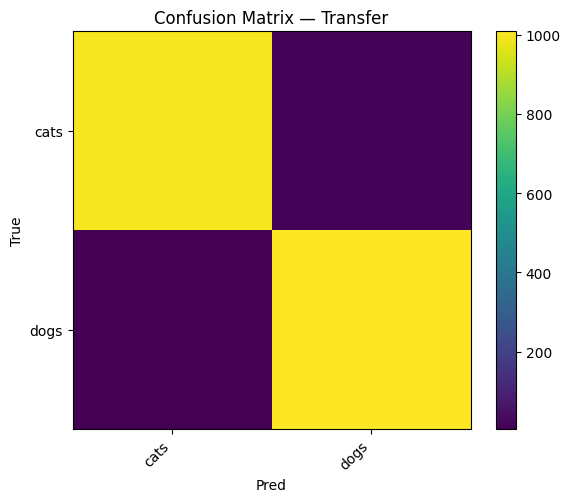

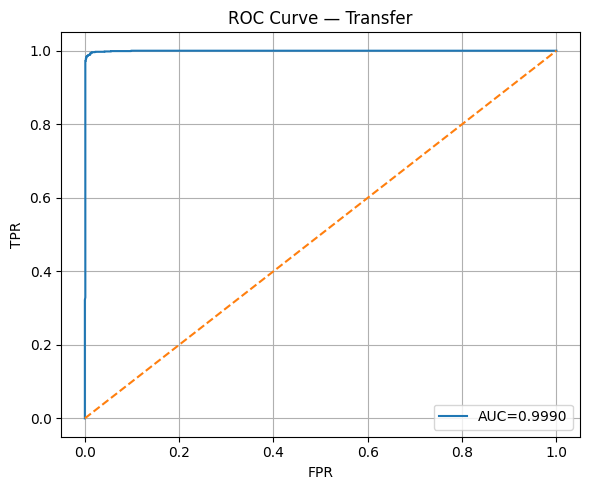

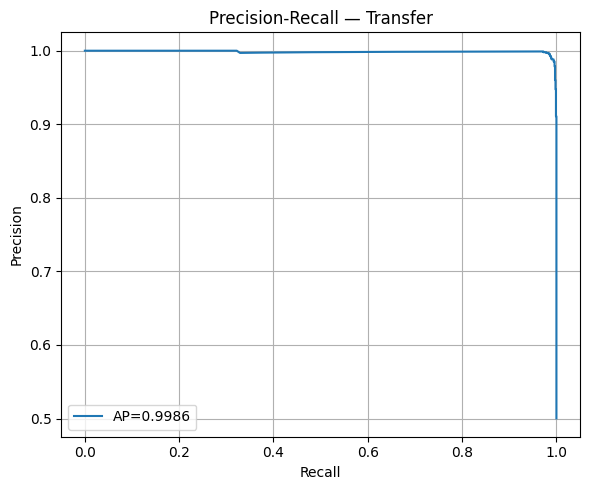

Macro F1: 0.9906
Saved model to: /kaggle/working/cats_vs_dogs_transfer.keras


In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


loss_t, acc_t = transfer.evaluate(test_ds, verbose=0)
print(f"[Transfer] Test Accuracy: {acc_t:.4f} | Test Loss: {loss_t:.4f}")


y_true, y_prob = [], []
for images, labels in test_ds:
    probs = transfer.predict(images, verbose=0).squeeze()
    y_prob.extend(probs.tolist()); y_true.extend(labels.numpy().tolist())
y_true = np.array(y_true); y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation='nearest'); plt.title("Confusion Matrix — Transfer")
plt.colorbar(); ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45, ha='right'); plt.yticks(ticks, class_names)
plt.ylabel("True"); plt.xlabel("Pred"); plt.tight_layout(); plt.show()

auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,5)); plt.plot(fpr, tpr, label=f"AUC={auc:.4f}"); plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve — Transfer"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

ap = average_precision_score(y_true, y_prob)
prec, rec, _ = precision_recall_curve(y_true, y_prob)
plt.figure(figsize=(6,5)); plt.plot(rec, prec, label=f"AP={ap:.4f}")
plt.title("Precision-Recall — Transfer"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

print("Macro F1:", round(f1_score(y_true, y_pred, average="macro"), 4))


SAVE_PATH = "/kaggle/working/cats_vs_dogs_transfer.keras"
transfer.save(SAVE_PATH)
print("Saved model to:", SAVE_PATH)


## Grad-CAM Görselleştirme
Modelin tahmin yaparken görüntünün **hangi bölgelerine odaklandığını** göstermek için Grad-CAM ısı haritaları ürettik.  
MobileNetV2’nin son konvolüsyon katmanı hedeflenerek (Conv_1 / out_relu) orijinal görüntü üzerine ısı haritası bindirildi.


In [4]:

import os, numpy as np, tensorflow as tf
from pathlib import Path
from tensorflow import keras


IMG_SIZE   = globals().get("IMG_SIZE", 224)
BATCH_SIZE = globals().get("BATCH_SIZE", 32)
SEED       = globals().get("SEED", 42)
AUTOTUNE   = tf.data.AUTOTUNE

import kagglehub
path = kagglehub.dataset_download("tongpython/cat-and-dog")
base_dir = Path(path)

train_root = base_dir / "training_set" / "training_set"
test_root  = base_dir / "test_set" / "test_set"

print("Train root:", train_root)
print("Test  root:", test_root)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_root,
    labels="inferred",
    label_mode="int",
    validation_split=0.10,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_root,
    labels="inferred",
    label_mode="int",
    validation_split=0.10,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_root,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
print("Classes:", class_names)


train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Train root: /kaggle/input/cat-and-dog/training_set/training_set
Test  root: /kaggle/input/cat-and-dog/test_set/test_set
Found 8005 files belonging to 2 classes.
Using 7205 files for training.
Found 8005 files belonging to 2 classes.
Using 800 files for validation.
Found 2023 files belonging to 2 classes.
Classes: ['cats', 'dogs']


In [5]:

import numpy as np, tensorflow as tf, matplotlib.pyplot as plt, glob, os
from tensorflow import keras
from tensorflow.keras import layers


if "transfer" in globals():
    model_for_cam = transfer
else:
    cands = sorted(glob.glob("/kaggle/working/*.keras"), key=os.path.getmtime, reverse=True)
    if not cands:
        raise FileNotFoundError(
            "Kaydedilmiş .keras bulunamadı. Transfer modelini kaydedip tekrar dener misin?"
        )
    print("Yüklenen model:", cands[0])
    model_for_cam = keras.models.load_model(cands[0])


def _find_last_conv_in_model(model: keras.Model):
    
    base = None
    for L in model.layers:
        if isinstance(L, keras.Model) and "mobilenetv2" in L.name.lower():
            base = L
            break
    scan_layers = base.layers if base is not None else model.layers
    for L in reversed(scan_layers):
        if isinstance(L, layers.Conv2D):
            return L
    raise ValueError("Modelde Conv2D katmanı bulunamadı.")


def make_gradcam_heatmap(img_array, model):
    last_conv_layer = _find_last_conv_in_model(model)
    grad_model = keras.Model([model.input], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array, training=False)
        pred_index = tf.argmax(preds[0])
        target = preds[:, pred_index]

    grads  = tape.gradient(target, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_out = conv_out[0]                               # (H, W, C)
    heatmap  = conv_out @ pooled[..., tf.newaxis]        # (H, W, 1)
    heatmap  = tf.squeeze(heatmap)
    heatmap  = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


def show_gradcam_on_image(dataset, model, class_names, num_images=6, img_size=224, alpha=0.35):
    imgs, labs = next(iter(dataset.unbatch().batch(num_images)))
    plt.figure(figsize=(12, 2*num_images))
    for i in range(num_images):
        img = imgs[i].numpy()
        arr = np.expand_dims(img, 0).astype("float32")   # model içindeki preprocess varsa onu kullanır
        heat = make_gradcam_heatmap(arr, model)
        heat = tf.image.resize(heat[..., None], (img_size, img_size)).numpy().squeeze()

       
        plt.subplot(num_images, 2, 2*i+1); plt.imshow(img); plt.title("Image"); plt.axis("off")
        plt.subplot(num_images, 2, 2*i+2); plt.imshow(img); plt.imshow(heat, cmap="jet", alpha=alpha); plt.axis("off")

        prob = float(model.predict(arr, verbose=0).squeeze())
        pred = int(prob >= 0.5)
        plt.title(f"Grad-CAM — GT: {class_names[int(labs[i])]} | Pred: {class_names[pred]} ({prob:.2f})")
    plt.tight_layout(); plt.show()


show_gradcam_on_image(test_ds, model_for_cam, class_names, num_images=6, img_size=IMG_SIZE, alpha=0.35)


FileNotFoundError: Kaydedilmiş .keras bulunamadı. Transfer modelini kaydedip tekrar dener misin?

In [2]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

assert "baseline" in globals(), "Önce baseline modelini eğitmiş olmalısın (baseline değişkeni RAM'de)."

# Son Conv2D'yi bul
def _last_conv(model):
    for L in reversed(model.layers):
        if isinstance(L, layers.Conv2D):
            return L
    raise ValueError("Baseline içinde Conv2D bulunamadı.")

def _heatmap(arr, model):
    last = _last_conv(model)
    grad_model = keras.Model(model.input, [last.output, model.output])
    with tf.GradientTape() as tape:
        conv, preds = grad_model(arr, training=False)
        target = preds[:, tf.argmax(preds[0])]
    grads  = tape.gradient(target, conv)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv   = conv[0]
    heat   = conv @ pooled[..., tf.newaxis]
    heat   = tf.squeeze(heat)
    heat   = tf.maximum(heat, 0) / (tf.reduce_max(heat) + 1e-8)
    return heat.numpy()

def show_cam_baseline(dataset, model, class_names, num_images=6, img_size=224, alpha=0.35):
    imgs, labs = next(iter(dataset.unbatch().batch(num_images)))
    plt.figure(figsize=(12,2*num_images))
    for i in range(num_images):
        img = imgs[i].numpy()
        arr = np.expand_dims(img, 0).astype("float32")
        heat = _heatmap(arr, model)
        heat = tf.image.resize(heat[..., None], (img_size,img_size)).numpy().squeeze()

        plt.subplot(num_images,2,2*i+1); plt.imshow(img); plt.title("Image"); plt.axis("off")
        plt.subplot(num_images,2,2*i+2); plt.imshow(img); plt.imshow(heat, cmap="jet", alpha=alpha); plt.axis("off")

        prob = float(model.predict(arr, verbose=0).squeeze()); pred = int(prob>=0.5)
        plt.title(f"Grad-CAM — GT: {class_names[int(labs[i])]} | Pred: {class_names[pred]} ({prob:.2f})")
    plt.tight_layout(); plt.show()

show_cam_baseline(test_ds, baseline, class_names, num_images=6, img_size=IMG_SIZE, alpha=0.35)


AssertionError: Önce baseline modelini eğitmiş olmalısın (baseline değişkeni RAM'de).

RAM'de baseline yok → hızlı eğitim (1 epoch) başlıyor…
226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.5107 - loss: 0.6949 - val_accuracy: 0.5225 - val_loss: 0.6890


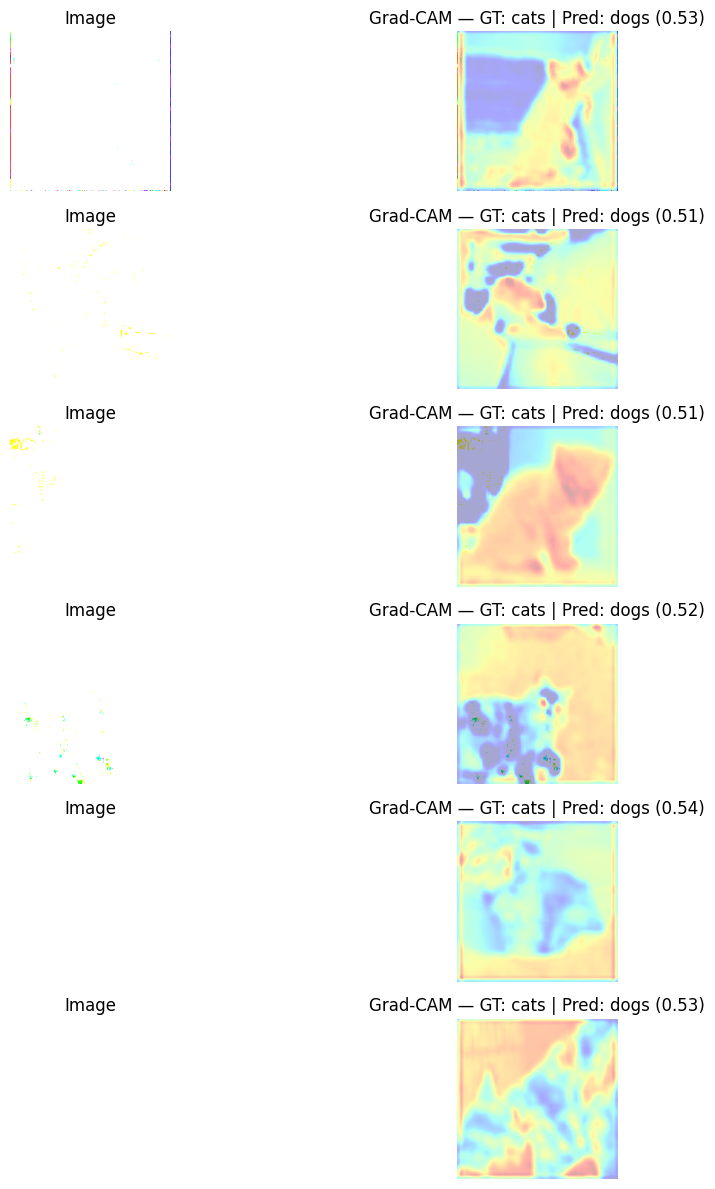

In [3]:

import numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers


IMG_SIZE = globals().get("IMG_SIZE", 224)


if "data_augmentation" not in globals():
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ], name="augmentation")
if "normalization" not in globals():
    normalization = layers.Rescaling(1./255)


def build_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), dropout=0.3):
    inp = keras.Input(shape=input_shape)
    x = data_augmentation(inp)
    x = normalization(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inp, out, name="baseline_cnn")

if "baseline" not in globals():
    print("RAM'de baseline yok → hızlı eğitim (1 epoch) başlıyor…")
    baseline = build_baseline_cnn()
    baseline.compile(optimizer=keras.optimizers.Adam(1e-3),
                     loss="binary_crossentropy", metrics=["accuracy"])
    baseline.fit(train_ds, validation_data=val_ds, epochs=1, verbose=1)
else:
    print("RAM'deki baseline kullanılacak.")


def _last_conv(model):
    for L in reversed(model.layers):
        if isinstance(L, layers.Conv2D):
            return L
    raise ValueError("Baseline içinde Conv2D katmanı bulunamadı.")

def _heatmap(arr, model):
    last = _last_conv(model)
    grad_model = keras.Model(model.input, [last.output, model.output])
    with tf.GradientTape() as tape:
        conv, preds = grad_model(arr, training=False)
        target = preds[:, tf.argmax(preds[0])]
    grads  = tape.gradient(target, conv)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv   = conv[0]                                 # (H,W,C)
    heat   = conv @ pooled[..., tf.newaxis]          # (H,W,1)
    heat   = tf.squeeze(heat)
    heat   = tf.maximum(heat, 0) / (tf.reduce_max(heat) + 1e-8)
    return heat.numpy()

def show_cam_baseline(dataset, model, class_names, num_images=6, img_size=224, alpha=0.35):
    imgs, labs = next(iter(dataset.unbatch().batch(num_images)))
    plt.figure(figsize=(12,2*num_images))
    for i in range(num_images):
        img = imgs[i].numpy()
        arr = np.expand_dims(img, 0).astype("float32")
        heat = _heatmap(arr, model)
        heat = tf.image.resize(heat[..., None], (img_size,img_size)).numpy().squeeze()

        plt.subplot(num_images,2,2*i+1); plt.imshow(img); plt.title("Image"); plt.axis("off")
        plt.subplot(num_images,2,2*i+2); plt.imshow(img); plt.imshow(heat, cmap="jet", alpha=alpha); plt.axis("off")

        prob = float(model.predict(arr, verbose=0).squeeze()); pred = int(prob>=0.5)
        plt.title(f"Grad-CAM — GT: {class_names[int(labs[i])]} | Pred: {class_names[pred]} ({prob:.2f})")
    plt.tight_layout(); plt.show()


show_cam_baseline(test_ds, baseline, class_names, num_images=6, img_size=IMG_SIZE, alpha=0.35)


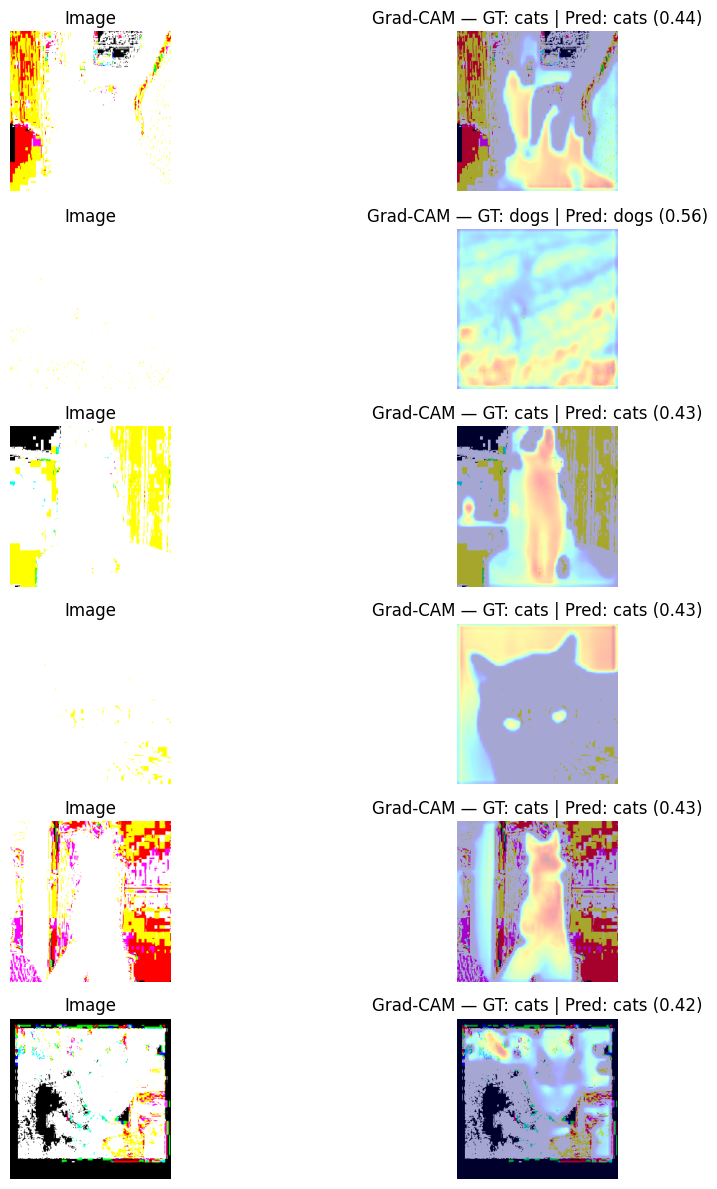

In [4]:

import numpy as np, tensorflow as tf

model_for_cam = baseline  # veya transfer
y_true, y_prob, images = [], [], []
for x, y in test_ds:
    p = model_for_cam.predict(x, verbose=0).squeeze()
    y_prob.extend(np.atleast_1d(p).tolist())
    y_true.extend(y.numpy().tolist())
    images.append(x.numpy())
y_true = np.array(y_true)
y_prob = np.array(y_prob)
images = np.concatenate(images, axis=0)

y_pred = (y_prob >= 0.5).astype(int)
correct_idx = np.where(y_pred == y_true)[0]


conf = np.abs(y_prob - 0.5)  
best_idx = correct_idx[np.argsort(conf[correct_idx])[-6:]]


chosen_ds = tf.data.Dataset.from_tensor_slices(
    (images[best_idx], y_true[best_idx])
).batch(6)

show_cam_baseline(chosen_ds, model_for_cam, class_names, num_images=6, img_size=IMG_SIZE, alpha=0.35)
